In [155]:
import numpy as np 
import io
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from PIL import Image
import torch
import torch.nn as nn
from matplotlib import gridspec
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms



DATASET

- You must use the Huggingface Emoji dataset for this project
- You should divide this subset into training, validation and test sets using a 60/20/20 ratio.

In [156]:

# Load the "emoji-dataset"
dataset = load_dataset("valhalla/emoji-dataset")
def split_dataset(dataset):
    # Split the dataset into training, testing, and validation sets
    train_ratio = 0.6
    test_ratio = 0.4
    validation_ratio = 0.5

    # Use the train_test_split function to create the splits
    splits = dataset["train"].train_test_split(
        test_size=test_ratio,
        train_size=train_ratio,
        shuffle=True,
        # split_seed=42  # You can change this seed for reproducibility
    )

    # Access the resulting splits
    train_dataset = splits["train"]
    test_dataset = splits["test"]

    # Further split the train_dataset for validation
    train_splits = test_dataset.train_test_split(
        test_size=validation_ratio,
        train_size=1 - validation_ratio,
        shuffle=True,
        # split_seed=42
    )

    # Access the resulting splits
    test_dataset = train_splits["train"]
    validation_dataset = train_splits["test"]

    # Print the number of examples in each split
    print(f"Train: {len(train_dataset)} examples")
    print(f"Test: {len(test_dataset)} examples")
    print(f"Validation: {len(validation_dataset)} examples")
    return train_dataset, test_dataset, validation_dataset

train_dataset, test_dataset, validation_dataset = split_dataset(dataset)

Train: 1649 examples
Test: 550 examples
Validation: 550 examples


- You should use the image “text” to select a related subset of images to work with (e.g.,
“face”, “superhero”, etc.).

In [169]:
## Specify the text you want to match
def filter_training(dataset, target_text) :

    # Function to filter images based on text
    def filter_by_text(example):
        return target_text in example["text"]

    # Apply the filter function to get matching examples
    matching_examples = train_dataset.filter(filter_by_text)
    return matching_examples


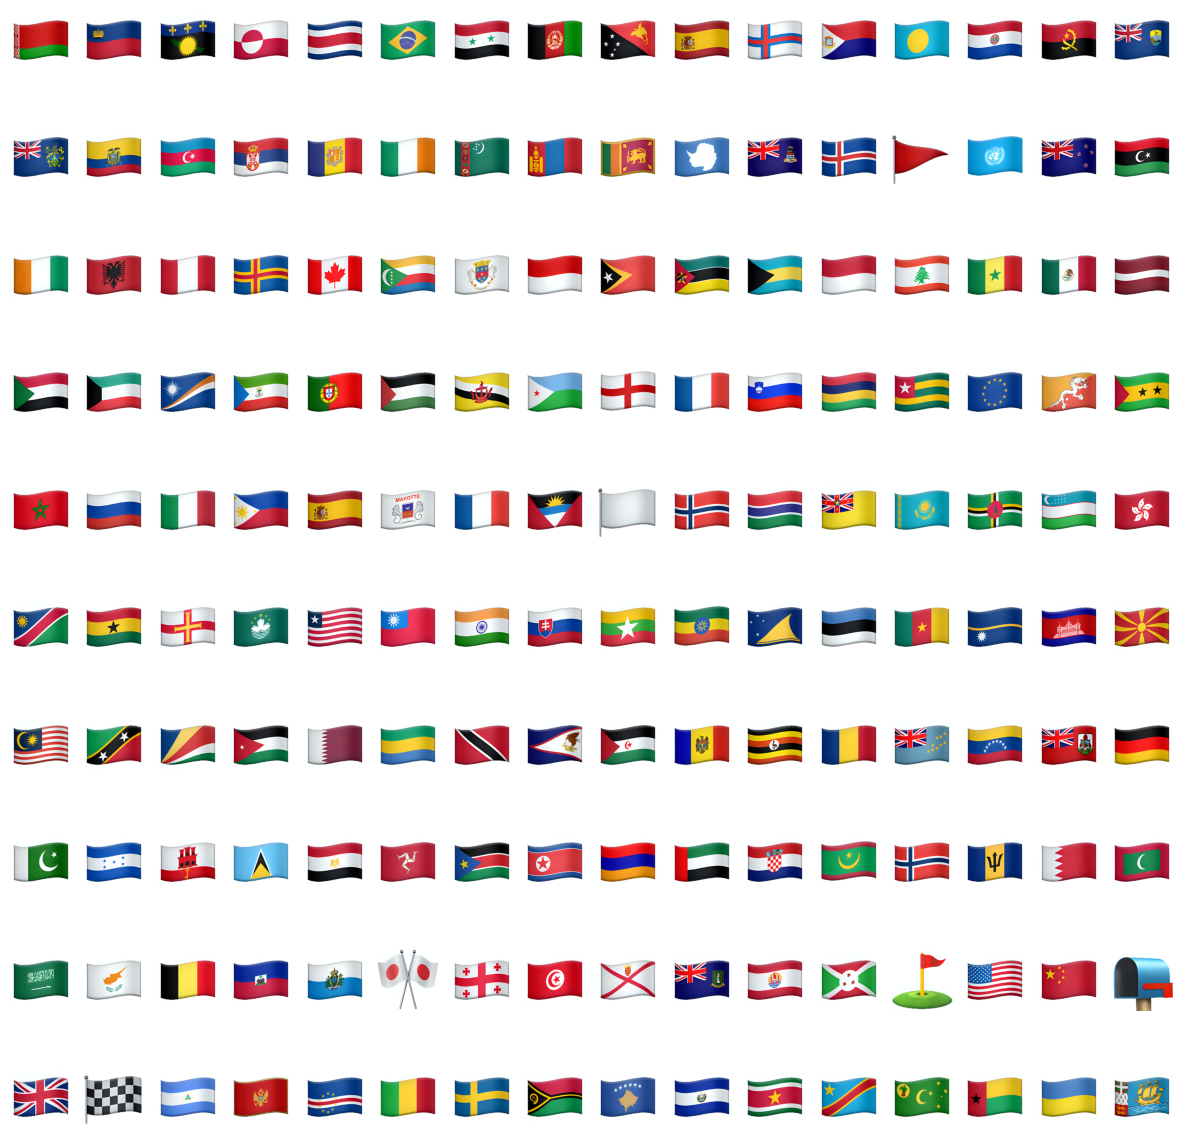

In [170]:
def show_images(images, figsize=(15, 15), rows=10):
    fig, axes = plt.subplots(rows, len(images) // rows, figsize=figsize)

    if len(images) == 1:
        axes = [axes]

    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(title)

    plt.show()
# Display the matching images
target_text = "flag"  # Replace with your specific text
show_images(filter_training(train_dataset, target_text)['image'])

- You are encouraged to reduce the resolution of the dataset to something appropriate for
computational resources (e.g., 64 x 64 x 3).

In [114]:

def reshape_dataset(dataset):
    image_list = []
    for example in dataset:
        image = example['image']
        # Resize the image to 64x64 pixels
        resized_image = image.resize((64, 64))
        # Convert the image to a NumPy array
        image_array = np.array(resized_image)
        image_list.append(image_array)
    # Convert the list of arrays to a single NumPy array
    images = np.array(image_list)
    print(f"Image size: {images.shape}")
    print(f"Number of images: {len(image_list)}")
    return images

# Assuming train_dataset is your dataset
len_train_dataset = len(train_dataset)
images = reshape_dataset(train_dataset)

# Check if the length matches
print(f"Length of train_dataset: {len_train_dataset}")

# Batch and shuffle the data using DataLoader
# batch_size = BATCH_SIZE
# shuffle = True  # Set to True if you want to shuffle the data
# train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)

Image size: (1649, 64, 64, 3)
Number of images: 1649
Length of train_dataset: 1649


Constructing the Generating Neural Network

- fully connected layer that takes an input from noise_dim and outputs to a size of 1024.
- A ReLU activation function.
- Another fully connected layer, this time maintaining a size of 1024.
- nother ReLU activation function.
- A final fully connected layer with a size of 784.
- A TanH activation function, which is used to ensure the output image values are within the range of -1 to 1.

From the Paper:
Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers|
- Item 1



In [120]:
def generator_model(input_size, hidden_size):
    layer1 = [
        nn.Linear(in_features=input_size, out_features=hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        # allows the gradients to flow better through the model 
        nn.LeakyReLU(inplace=True)
    ]
    layer2 = [
        nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True)
            
    ]
    layer3 = [
        nn.ConvTranspose2d(128, 1, kernel_size=(3, 3), padding=(1, 1), bias=False),
        nn.Tanh()
    ]
    layers = layer1 + layer2 + layer3
    model = nn.Sequential(*layers)
    return model

In [121]:
input_size = 100
hidden_size = 7*7*256 
generator = generator_model(input_size,hidden_size)
noise = torch.randn(1, input_size)
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 12544])

In [116]:
# def make_generator_model():
#     model = nn.Sequential(
#         nn.Linear(100, 7*7*256, bias=False),
#         nn.BatchNorm1d(7*7*256),
#         nn.LeakyReLU(0.2, inplace=True),
        
#         # nn.Reshape((256, 7, 7)),
#         nn.Unflatten(1, (256, 7, 7)),

#         nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False),
#         nn.BatchNorm2d(128),
#         nn.LeakyReLU(0.2, inplace=True),
        
#         nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
#         nn.BatchNorm2d(64),
#         nn.LeakyReLU(0.2, inplace=True),
        
#         nn.ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
#         nn.Tanh()
#     )

#     return model


In [118]:
# input_size = 100
# hidden_size = 7*7*256 
# output_size = 0
# generator = make_generator_model()
# noise = torch.randn(1, input_size)
# generated_image = generator(noise)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 12544])

In [34]:
def discriminator_model():
    layer1 = [
        nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
    ]
    layer2 = [
        nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
            
    ]
    layer3 = [
        nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
    ]
    layers = layer1 + layer2 + layer3 + [nn.Flatten(), nn.Linear(256 * 4 * 4, 1)]

    model = nn.Sequential(*layers)
    return model
discriminator = discriminator_model()
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (4): LeakyReLU(negative_slope=0.01, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (7): LeakyReLU(negative_slope=0.01, inplace=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4096, out_features=1, bias=True)
)


In [35]:
def generator_loss(fake_output):
    target = torch.ones_like(fake_output)
    F.mse_loss(fake_output, target)

In [36]:
def discriminator_loss(real_output, fake_output):
    target_real = torch.ones_like(real_output)
    target_fake = torch.zeros_like(fake_output)

    real_loss = F.mse_loss(real_output, target_real)
    fake_loss = F.mse_loss(fake_output, target_fake)

    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
# Assuming images is a PyTorch tensor

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16
seed = torch.randn(num_examples_to_generate, noise_dim)

# Assuming you already have generator, discriminator, generator_loss, discriminator_loss defined

# Initialize optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
def train_step(images):
    noise = torch.randn(images.size(0), noise_dim)

    # Generator forward pass
    generated_images = generator(noise)

    # Discriminator forward pass for real and fake images
    real_output = discriminator(images)
    fake_output = discriminator(generated_images.detach())

    # Calculate losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    # Backpropagation
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    gen_loss.backward(retain_graph=True)
    disc_loss.backward()

    # Update weights
    generator_optimizer.step()
    discriminator_optimizer.step()

AttributeError: 'PngImageFile' object has no attribute 'dtypes'

In [47]:
for epoch in range(EPOCHS):
    for batch_images in train_dataset:  # Assuming each batch is a tuple of (images, labels)
        transform = transforms.ToTensor()
        # Apply the transform to each image in the batch
        transformed_images = [transform(img) for img in np.array(batch_images['image'])]
        # Convert the list of transformed images to a torch tensor
        transformed_images = torch.stack(transformed_images)
        train_step(transformed_images)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [256, 12544]